In [1]:
import pdal
import json
import geopandas as gpd
import folium
from pyproj import Proj, transform
from shapely.geometry import Polygon, Point, mapping
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
# Loading and reading the json file
def read_json(json_path):
    try:
        with open(json_path) as js:
            json_obj = json.load(js)
        return json_obj

    except FileNotFoundError:
        print('File not found.')

In [3]:
# Changing to the needed CRS format for better visualization

def convert_EPSG(fromT, lon, lat):
    P3857 = Proj(init='epsg:3857')
    P4326 = Proj(init='epsg:4326')
    if(fromT == 4326):
        input1 = P4326
        input2 = P3857
    else:
        input1=p3857
        input2=p4326
        
    x, y = transform(input1,input2, lon, lat)
    return [x, y]

In [4]:
# Changing format of a list
    
def loop_EPSG_converter(listin):
    converted = []
    for item in listin:
        converted.append(convert_EPSG(4326, item[0], item[1]))
        
    return converted

In [5]:
# Generating a polygon given a co-ordinate and CRS format

def generate_polygon(coor, epsg):
    polygon_g = Polygon(coor)
    crs = {'init': 'epsg:'+str(epsg)}
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_g])       
    return polygon

In [6]:
# Generating a data frame given a CRS format and pipe

def generate_geo_df(pipe, epsg):
    try:
        cloud_points = []
        elevations =[]
        geometry_points=[]
        for row in pipe.arrays[0]:
            lst = row.tolist()[-3:]
            cloud_points.append(lst)
            elevations.append(lst[2])
            point = Point(lst[0], lst[1])
            geometry_points.append(point)
        geodf = gpd.GeoDataFrame(columns=["elevation", "geometry"])
        geodf['elevation'] = elevations
        geodf['geometry'] = geometry_points
        geodf = geodf.set_geometry("geometry")
        geodf.set_crs(epsg = epsg, inplace=True)
        return geodf
    except RuntimeError as e:
        print(e)

In [7]:
# Co-ordinates for the polygon and generating the polygon from the given co-ordinate

coordinates = [
    [-93.756055, 41.918115],
    [-93.756155, 41.918215],
    [-93.756396, 41.918475],
    [-93.755955, 41.918300],
    [-93.755795, 41.918000],
]


polygon = generate_polygon(coordinates, 4326)

In [8]:
# A function to display the polygon on a map

def show_on_map(polygon, zoom):
    #region selection
    poly = mapping((polygon.iloc[:,0][0]))
    tmp = poly['coordinates'][0][0]
    anchor = [tmp[1], tmp[0]]
    map = folium.Map(anchor,zoom_start=zoom, tiles='cartodbpositron')
    folium.GeoJson(polygon).add_to(map)
    folium.LatLngPopup().add_to(map)
    return map

show_on_map(polygon, 20)

In [9]:
# Changing the co-ordinates of the polygon to the standard EPSG CRS format and generating a polgon

coor = loop_EPSG_converter(coordinates)
print(coor)
polygon_standard = generate_polygon(coor, 4326)

[[-10436876.301386151, 5148721.349314567], [-10436887.43333523, 5148736.309605352], [-10436914.26133251, 5148775.206471106], [-10436865.169437071, 5148749.025870951], [-10436847.358318545, 5148704.145009145]]


In [10]:
# Modifying the already created json file to fetch the data

def modify_pipe_json(json_loc, url, region, in_epsg, out_epsg):
    dicti = read_json(json_loc)
    dicti['pipeline'][0]['polygon'] = str(polygon_standard.iloc[:,0][0])
    dicti['pipeline'][0]['filename'] = f"{url}/{region}/ept.json"
    dicti['pipeline'][2]['in_srs'] = f"EPSG:{in_epsg}"
    dicti['pipeline'][2]['out_srs'] = f"EPSG:{out_epsg}"
    print(dicti)
    return dicti
    
location = "../iowa.json"
url = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public"
region = "IA_FullState"
in_srs = 3857
out_srs = 4326

request = modify_pipe_json(location, url, region, in_srs, out_srs)

{'pipeline': [{'polygon': 'POLYGON ((-10436876.301386151 5148721.349314567, -10436887.43333523 5148736.309605352, -10436914.26133251 5148775.206471106, -10436865.169437071 5148749.025870951, -10436847.358318545 5148704.145009145, -10436876.301386151 5148721.349314567))', 'filename': 'https://s3-us-west-2.amazonaws.com/usgs-lidar-public/IA_FullState/ept.json', 'type': 'readers.ept', 'tag': 'readdata'}, {'type': 'filters.range', 'limits': 'Classification![7:7]', 'tag': 'no_noise'}, {'in_srs': 'EPSG:3857', 'out_srs': 'EPSG:4326', 'tag': 'reprojectUTM', 'type': 'filters.reprojection'}, {'filename': 'iowa.csv', 'tag': 'writerscsv', 'type': 'writers.text'}, {'filename': 'iowa.las', 'tag': 'writersply', 'type': 'writers.las'}]}


In [11]:
pipe = pdal.Pipeline(json.dumps(request))

In [12]:
pipe.execute()

1371

In [13]:
# Generating the dataframe

df = generate_geo_df(pipe, 4326)

Text(88.875, 0.5, 'Latitude')

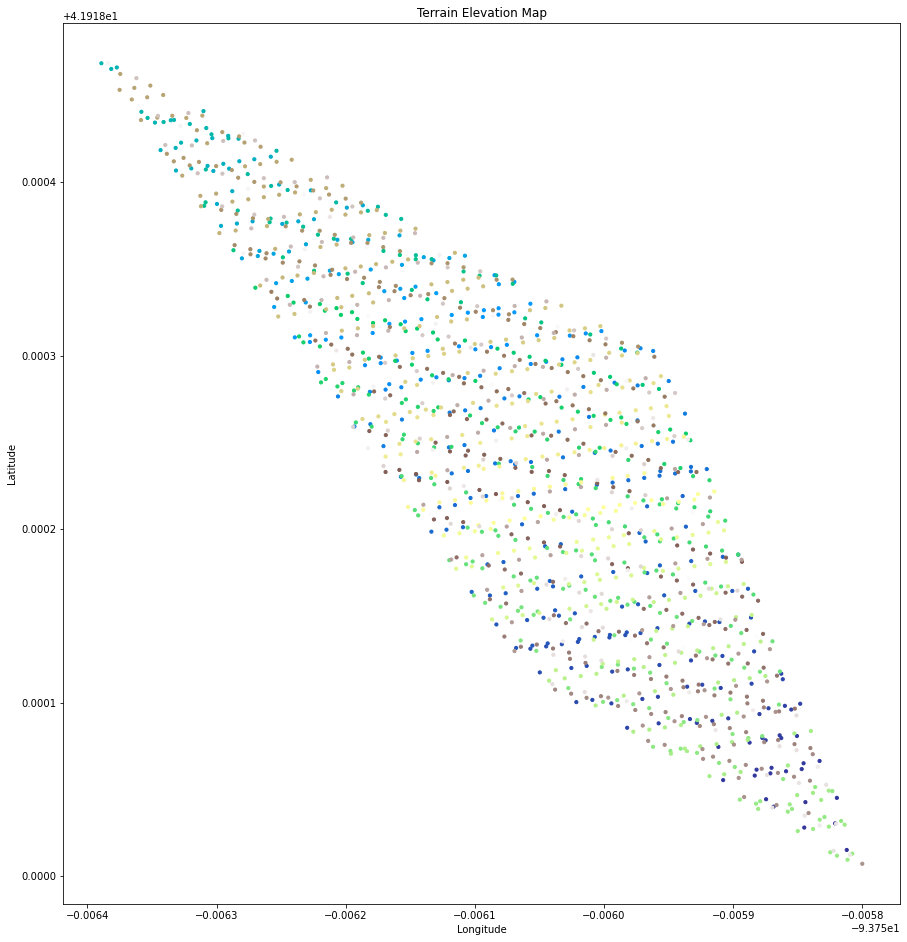

In [14]:
df.plot(c='elevation', scheme="quantiles", cmap='terrain', legend=True,
                                  markersize=10,
                                  figsize=(15, 20),
                                  missing_kwds={
                                    "color": "lightgrey",
                                    "edgecolor": "red",
                                    "hatch": "///",
                                    "label": "Missing values"}
                                  )

plt.title('Terrain Elevation Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')